In [1]:
# Repurposed SWRanalysis code to analyze powers for CA1 v. DG electrodes. Similar to
# Fig. 6 in Solomon NatComm 2018. Want to assess from range 50:300 Hz a la Sullivan et al 2011

In [294]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
exp = 'FR1' # 'FR1' 'catFR1'
HPC_labels,ENT_labels,PHC_labels = getMTLregions(MTL_labels)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [315]:
# sub lists I've been using to explore FR1 

# subs = ['R1002P','R1003P','R1006P','R1010J','R1112M','R1163T'] # initial 6 for hippocampus
# subs = subs+['R1001P','R1092J','R1151E','R1320D'] # additional subs with issues that I resolved with various RR and corr thresholds
# subs = ['R1112M','R1018P','R1020J','R1022J','R1023J','R1026D','R1027J'] # 7 with entorhinal
# subs = ['R1010J','R1112M'] # original 2 # R1108J beatiful catFR1 data; R1065J magical subject (like with FR1)
# subs = ['R1112M','R1163T'] # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
# subs = ['R1151E'] # all channels X sessions get removed but 3 after 60/180 hz line removal
# these should all be worked out now. See SWR FR1 problem sessions PPT on Box for details of each
# subs = ['R1299T','R1332M','R1397D','R1349T','R1339D','R1337E','R1275D','R1151E','R1123C','R1120E','R1045E'] # final surrounding_recall problem subs after looking at huge raster!
# subs = ['R1308T','R1338T','R1358T'] # these guys had weird SRs and some loading problems when I went to whole_retrieval analysis...fixed with rounding
# subs = ['R1023J','R1101T','R1148P','R1368T','R1323T','R1334T'] # single session subs with memory allocation errors in ClusterRun
# subs = ['R1006P','R1010J','R1030J','R1032D','R1049J','R1051J','R1052E','R1054J','R1093J','R1098D','R1104D','R1108J','R1111M',
#         'R1115T','R1118N','R1124J','R1207J','R1230J','R1316T','R1329T','R1323T','R1337E','R1367D'] # subs that didn't load on 2020-07-04 encoding run
# subs = ['R1368T','R1461T','R1463E'] # subs with particularly low localization.pair matches in pairs...see Excel in loading info on Box for details
# subs = ['R1433E','R1355T','R1367D','R1368T'] # subs with "ca3" or "dg"
subs = ['R1065J'] # subject with over 8000 FR1 trials X electrodes
# bad_subs = ['R1433E','R1051J'] # no electrode cats
# subs = ['R1379E','R1385E','R1387E','R1394E','R1402E'] # partial beep subs
# subs = ['R1379E','R1402E','R1396T','R1395M','R1415T','R1389J','R1404E']  # test subs for eeg offset correction
# subs = ['R1048E','R1054J'] # nice example FR1 subs
# subs = ['R1048E','R1112M'] # couple of FR1 subs
subs = ['R1056M']

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
sub_df = sub_df[0:1]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
284,NaN,protocols/r1/subjects/R1056M/experiments/FR1/s...,protocols/r1/subjects/R1056M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1056M/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1056M/localizations/0/m...,NaN,0,R1056M,R1056M,1.0,protocols/r1/subjects/R1056M/experiments/FR1/s...


In [296]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                    ] 
if exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
                    ]
exp_df.shape
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df[404:413]
exp_df

# Makes most sense to take half the subjects 
if exp == 'FR1':
    np.random.seed(44462) # seed 44462 gives 25,845 of 60,417 recall trials (42.8%). Or 57/167 (34.1% of subs)
    from SWRmodule import total_sub_names_FR1 # all the unique sub names for FR1 task in df
    total_sub_names = copy(total_sub_names_FR1)
    proportion_subs = 0.5 # it's really 0.5 of initial pre-localization.pairs subs. So comes out to numbers above. And what we want to match for catFR1
elif exp == 'catFR1':
    np.random.seed(44455) # seed 44455 gives 20,393 of 50,053 recall trials (40.7%). Or 47/136 (34.6% of subs)
    from SWRmodule import total_sub_names_catFR1 # all the unique sub names for FR1 task in df
    total_sub_names = copy(total_sub_names_catFR1)
    proportion_subs = 0.35 # 0.5
random_half_sub_names = np.random.permutation(np.unique(total_sub_names))[:int(np.floor(len(np.unique(total_sub_names))*proportion_subs))]
random_half_sub_names[:10] # just to see them
random_half_sub_names[-10:]
half_sub_idxs = np.array(findAinB(random_half_sub_names,exp_df.subject))
half_df = exp_df.iloc[half_sub_idxs]
half_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(554, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
0,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,0,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
1,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,1,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
9,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
10,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
17,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,0,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2149,NaN,protocols/r1/subjects/R1462M/experiments/FR1/s...,protocols/r1/subjects/R1462M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1462M/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1462M/localizations/0/m...,NaN,0,R1462M,R1462M,3.4,protocols/r1/subjects/R1462M/experiments/FR1/s...
2151,NaN,protocols/r1/subjects/R1463E/experiments/FR1/s...,protocols/r1/subjects/R1463E/localizations/1/m...,FR1,build,1,protocols/r1/subjects/R1463E/experiments/FR1/s...,1,NaN,0,protocols/r1/subjects/R1463E/localizations/1/m...,NaN,0,R1463E,R1463E_1,3.4,protocols/r1/subjects/R1463E/experiments/FR1/s...
2152,NaN,protocols/r1/subjects/R1463E/experiments/FR1/s...,protocols/r1/subjects/R1463E/localizations/1/m...,FR1,build,1,protocols/r1/subjects/R1463E/experiments/FR1/s...,1,NaN,1,protocols/r1/subjects/R1463E/localizations/1/m...,NaN,1,R1463E,R1463E_1,3.4,protocols/r1/subjects/R1463E/experiments/FR1/s...
2166,NaN,protocols/r1/subjects/R1466J/experiments/FR1/s...,protocols/r1/subjects/R1466J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1466J/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1466J/localizations/0/m...,NaN,0,R1466J,R1466J,3.4,protocols/r1/subjects/R1466J/experiments/FR1/s...


array(['R1325C', 'R1310J', 'R1077T', 'R1288P', 'R1044J', 'R1108J',
       'R1002P', 'R1131M', 'R1316T', 'R1215M'], dtype='<U6')

array(['R1306E', 'R1137E', 'R1105E', 'R1048E', 'R1138T', 'R1122E',
       'R1094T', 'R1236J', 'R1120E', 'R1338T'], dtype='<U6')

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
9,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
10,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
83,NaN,protocols/r1/subjects/R1020J/experiments/FR1/s...,protocols/r1/subjects/R1020J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1020J/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1020J/localizations/0/m...,NaN,0,R1020J,R1020J,NaN,protocols/r1/subjects/R1020J/experiments/FR1/s...
93,NaN,protocols/r1/subjects/R1022J/experiments/FR1/s...,protocols/r1/subjects/R1022J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1022J/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1022J/localizations/0/m...,NaN,0,R1022J,R1022J,NaN,protocols/r1/subjects/R1022J/experiments/FR1/s...
126,NaN,protocols/r1/subjects/R1027J/experiments/FR1/s...,protocols/r1/subjects/R1027J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1027J/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1027J/localizations/0/m...,NaN,0,R1027J,R1027J,1.0,protocols/r1/subjects/R1027J/experiments/FR1/s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,NaN,protocols/r1/subjects/R1338T/experiments/FR1/s...,protocols/r1/subjects/R1338T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1338T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1338T/localizations/0/m...,NaN,0,R1338T,R1338T,3.1,protocols/r1/subjects/R1338T/experiments/FR1/s...
1743,NaN,protocols/r1/subjects/R1338T/experiments/FR1/s...,protocols/r1/subjects/R1338T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1338T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1338T/localizations/0/m...,NaN,1,R1338T,R1338T,3.1,protocols/r1/subjects/R1338T/experiments/FR1/s...
1744,NaN,protocols/r1/subjects/R1338T/experiments/FR1/s...,protocols/r1/subjects/R1338T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1338T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1338T/localizations/0/m...,NaN,2,R1338T,R1338T,3.1,protocols/r1/subjects/R1338T/experiments/FR1/s...
1757,NaN,protocols/r1/subjects/R1342M/experiments/FR1/s...,protocols/r1/subjects/R1342M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1342M/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1342M/localizations/0/m...,NaN,0,R1342M,R1342M,3.1,protocols/r1/subjects/R1342M/experiments/FR1/s...


In [297]:
## similar to Solomon NatComm Fig. 6A-B

from PS3module import get_multitaper_power
from PS3module import get_multitaper_power_with_freqs
from PS3module import get_tfr_multitaper_power

## local run through all electrodes and get average power X freq arrays for those in CA1/DG/Ent

In [115]:
import mne
from scipy.signal import firwin,filtfilt,kaiserord
import pingouin as pg
%autoreload
HPC_labels,ENT_labels,PHC_labels = getMTLregions(MTL_labels)

### PARAMS ###

fmin_pow = 5; fmax_pow = 240
eeg_start = -500
eeg_end = 0
baseline_correct = False
notch_filter = False

# # if using multitaper_tfr
# test_freqs = np.arange(fmin_pow,fmax_pow+0.1,5) # for get_tfr_multitaper_power
# n_cycles = np.floor(test_freqs/2)
# TBW = 2

save_values = 0

selected_period = 'surrounding_recall' # surrounding_recall # whole_retrieval # encoding 
# there are three periods this code is set up to look at: periods aligned to recall, the entire retrieval period, and the encoding period
recall_type_switch = 6 # how do we select recalls?? Numbers 0:3
# 0: Original analysis taking only recalls without a recall in 2 s IRI before them
# 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur
# 2: test condition where we look at second recalls within IRI ONLY
# 3: ISOLATED only!
# 4: only first recall of every retrieval period
# 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
# 6: take only NOT first recall of every retrieval period
# 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
# 10: same as 0 but with no IRI (mostly just to see number of recalls)

selected_region = MTL_labels #HPC_labels # ENT_labels+HPC_labels 

filter_type = 'hamming' # 'butter' # Vaz used Butterworth from 80-120 Hz; Norman used Hamming from 70-180 Hz
# •Butterworth from Vaz et al: 2nd order from 80-120 ms, hilbert, select events >2 STD above mean of filtered traces.
#      Events >=25 ms long w/ max amp >3 SD were retained as ripples. Join adjacent ripples separated by <15 ms 
# •Hilbert from Norman et al: "70-180 Hz zero-lag linear-phase Hamming FIR filter w/ transition bandwidth of 5 Hz"
#      Then Hilbert, clip extreme to 4 SD, square this clipped, smooth w/ Kaiser FIR low-pass filter with 40 Hz cutoff,
#      mean and SD computed across entire experimental duration to define the threshold for event detection
#      Events from original (squared but unclipped) signal >4 SD above baseline were selected as candidate SWR events. 
#      Duration expanded until ripple power <2 SD. Events <20 ms or >200 ms excluded. Adjacent events <30 ms separation (peak-to-peak) merged.
# •Using IED detection from Vaz for 250 Hz highpass events (really 250-499). Norman uses 20-60 Hz events which is...odd.
#       See detectRipples code in module for this algorithm


# recall params
recall_minimum = 2000
IRI = 2000 # inter-ripple interval...remove ripples within this range (keep only first one and remove those after it)
retrieval_whole_time = 30000
# encoding params
encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700 # since minimum ISI is 0.75 s let's only plot the 500 ms before word on with a 200 ms buffer
# these aren't likely to be changed:
desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.

### END PARAMS ###

if 'entorhinal' in selected_region and 'left hippocampus' in selected_region:
    region_name = 'HPC_ENT'
elif 'entorhinal' in selected_region:
    region_name = 'ENT'
elif 'left hippocampus' in selected_region:
    region_name = 'HPC'
if selected_period == 'surrounding_recall':
    psth_start = -IRI # only makes sense to look at period <= IRI
    psth_end = IRI # how long to grab data after recall
elif selected_period == 'whole_retrieval':
    psth_start = -IRI # doesn't have to be IRI just 2000 ms is convenient
    psth_end = IRI+retrieval_whole_time
elif selected_period == 'encoding':
    psth_start = pre_encoding_time
    psth_end = encoding_time

ripple_array = []; fr_array = []; 
trial_nums = []; 
session_ct = 0; channel_ct = 0; total_channel_ct = 0
HPC_names = []; sub_names = []; sub_sess_names = []
electrodes_per_session = []
total_lists = 0; total_recalls = 0; kept_recalls = 0
align_adjust = 0
ent_elec_ct = []; sd_regions = []; not_sd_regions = []
ripple_ied_accum_ct = []
time_add_save = [];             
encoded_word_key_array = []
list_num_key = []

list_recall_num_array = []; rectime_array = []; recall_before_intrusion_array = [] # new ones added 2020-11-24
serialpos_array = [] # used to be encoding info but commandeered for surrounding_recalls ~~~
recall_position_array = []

trial_by_trial_correlation = []; elec_by_elec_correlation = []
elec_ripple_rate_array = []

channel_coords = []; electrode_labels = []

DG_pows = []; DG_baseline = []
CA1_pows = []; CA1_baseline = []
ENT_pows = []; ENT_baseline = []

for row in half_df.itertuples(): #sub_df.itertuples():   
    try:
        sub = row.subject; session = row.session; exp = row.experiment
        mont = int(row.montage); loc = int(row.localization)
        reader = CMLReadDFRow(row)
        evs = reader.load('task_events')
        evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)] # recalled word AND correct (from this list...no instrusions).        
        word_evs = evs[evs['type']=='WORD'] # get words 
        
        # select which recalls??         
        [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_free_recall,IRI,recall_minimum)
        
        _,nonrepeat_indicator = removeRepeatedRecalls(evs_free_recall,word_evs) # remove free recalls that happened more than once
        
        # let's make sure remaining recalls are not repeated, have eeg, and are not from non-practice lists
        good_recalls = selected_recalls_idxs & (nonrepeat_indicator>0) & np.array(evs_free_recall.eegoffset>-1) & np.array(evs_free_recall.list > -1)
        evs_free_recall = evs_free_recall[good_recalls]
        
        # get temp key of recalls that lead to intrusions ~~~
        pre_intrusion_recalls = getRecallsBeforeIntrusions(evs,evs_free_recall)

        if len(evs_free_recall)==0: #...and that any are left!
            continue

        # get output position in each list for this session's recalls
        session_corrected_list_ops = getOutputPositions(evs,evs_free_recall)
            
        pairs = reader.load('pairs')
        try:
            localizations = reader.load('localization')
        except:
            localizations = []
        tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
        elec_regions,atlas_type,pair_number,has_stein_das = get_elec_regions(localizations,pairs) 

#         # count elec regions with specific string...mostly here to comment out below and test for good sessions
#         if len(findAinB(ENT_labels,elec_regions))>0:
#             ent_ct = len(findAinB(ENT_labels,elec_regions))
#             ent_elec_ct = np.append(ent_elec_ct,sub+'_'+str(session)+'_ct-'+str(ent_ct))

        # load eeg
        if selected_period == 'surrounding_recall':
            total_recalls = total_recalls + len(evs_free_recall) # get total recalls from lists
            total_lists = total_lists + len(evs[evs.type=='WORD'].list.unique()) # get total lists
            kept_recalls = kept_recalls + len(evs_free_recall)
            eeg_events = evs_free_recall
        elif selected_period == 'whole_retrieval':
            # grab whole retrieval periods for a better baseline of SWRs
            evs_rets = evs[evs.type=='REC_START']
            evs_rets = evs_rets[evs_rets.list>-1] # remove practice lists
            evs_rets = evs_rets[evs_rets.eegoffset>-1] # any trial with no eeg gets removed by cmlreaders so it's not in ripple_array 
            eeg_events = evs_rets
            
            # get alignmnet of end of beep time to EEG so can align retrieval to end of beep across all sessions
            align_adjust = getRetrievalStartAlignmentCorrection(sub,session,exp) # in ms
            
        elif selected_period == 'encoding':
            ## apparently there are repeated words?? should add program to check and remove
            # I'm going to save encoding word events too, but need a mask to keep track of:
            # 0) words not recalled 1) words recalled from this list 2) words later recalled BUT IRI<2 s so removed
            evs_encoding_words = evs[evs.type=='WORD']
            evs_encoding_words = evs_encoding_words[evs_encoding_words.list>-1]            
            evs_encoding_words = evs_encoding_words[evs_encoding_words.eegoffset>-1]
            encoded_word_key = np.zeros(len(evs_encoding_words)) # 0 for not recalled
            encoded_word_key[evs_encoding_words.recalled==True] = 2 # 2 for recalled but removed bc IRI<2 s
            encoded_word_key[evs_encoding_words.item_name.isin(evs_free_recall.item_name.unique())] = 1 # recalled words
            # since finding all encoding words IN the list of correctly free recalled words won't have any intrusions
            eeg_events = evs_encoding_words

        # fixing bad trials
        if sub == 'R1045E' and exp=='FR1': # this one session has issues in eeg trials past these points so remove events
            if selected_period == 'surrounding_recall':
                eeg_events = eeg_events.iloc[:65,:] # only the first 66 recalls have good eeg
            elif selected_period == 'whole_retrieval':
                eeg_events = eeg_events.iloc[:20,:] # only the first 20 retrieval periods have good eeg
            elif selected_period == 'encoding':
                eeg_events = eeg_events.iloc[:263,:] # same idea
                encoded_word_key = encoded_word_key[:263]
                
        # fix EEG offset due to Unity implementation error @@
#         init_time = eeg_events.iloc[0].eegoffset
        eeg_events = correctEEGoffset(sub,session,exp,reader,eeg_events)
#         print(sub+'-'+str(session)+'-'+exp+': '+str(eeg_events.iloc[0].eegoffset-init_time))

        eeg = reader.load_eeg(events = eeg_events, rel_start=eeg_start-1000, rel_stop=eeg_end,
                             clean=True, scheme=pairs)    
    
        eeg = eeg.to_ptsa()

        if baseline_correct == True:
            eeg = eeg.baseline_corrected((eeg_start,eeg_end))

        if notch_filter == True:
            from ptsa.data.filters import ButterworthFilter
            eeg = ButterworthFilter(timeseries=eeg, freq_range=[58.,62.], filt_type='stop', order=4).filter()
            eeg = ButterworthFilter(timeseries=eeg, freq_range=[118.,122.], filt_type='stop', order=4).filter()
            eeg = ButterworthFilter(timeseries=eeg, freq_range=[178.,182.], filt_type='stop', order=4).filter()
        else:
            pass   
        
        # Use MNE to get multitaper spectral power
        eeg_length = eeg_end-eeg_start+1000 # to get baseline 1 second earlier
        # linear frequencies
#         pows = get_tfr_multitaper_power(eeg, test_freqs, n_cycles, TBW, [eeg_buffer,eeg_length-eeg_buffer])
        #   this does log scale
        pows,freqs_done = get_multitaper_power_with_freqs(eeg, time=[1000,eeg_length],freqs = np.array([fmin_pow, fmax_pow]))
        pows_baseline,_ = get_multitaper_power_with_freqs(eeg, time=[0,eeg_end-eeg_start],freqs = np.array([fmin_pow, fmax_pow]))
        
        # get bad channel mask
        try:
            elec_cats = reader.load('electrode_categories') # this is cool
        except:
            if remove_soz_ictal == True:
                e = 'No electrode categories for '+sub+', session '+str(session)
                LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
                continue
            else:
                elec_cats = []
            
        bad_bp_mask = getBadChannels(tal_struct,elec_cats,remove_soz_ictal)
        
        electrode_search_range = getElectrodeRanges(elec_regions,exp,sub,session,mont)

        region_electrode_ct = 0
        session_ripple_rate_by_elec = []
        for channel in electrode_search_range:
            if (elec_regions[channel] in selected_region) & \
            (bad_bp_mask[channel] == 0): # don't use bad electrodes                
               
                total_channel_ct+=1 # total channels before artifact removal
                
                if elec_regions[channel] in ['left dg','right dg','"dg"','dg']:
#                     DG_pows = superVstack(DG_pows,pows[:,channel])
                    DG_pows = superVstack(DG_pows,np.mean(np.log10(pows[:, :, :]), 0)[channel])
                    DG_baseline = superVstack(DG_baseline,np.mean(np.log10(pows_baseline[:, :, :]), 0)[channel])
                elif elec_regions[channel] in ['left ca1','right ca1','"ca1"','ca1']:
#                     CA1_pows = superVstack(CA1_pows,pows[:,channel])
                    CA1_pows = superVstack(CA1_pows,np.mean(np.log10(pows[:, :, :]), 0)[channel])
                    CA1_baseline = superVstack(CA1_baseline,np.mean(np.log10(pows_baseline[:, :, :]), 0)[channel])
                elif elec_regions[channel] in ENT_labels:
                    ENT_pows = superVstack(ENT_pows,np.mean(np.log10(pows[:, :, :]), 0)[channel])
                    ENT_baseline = superVstack(ENT_baseline,np.mean(np.log10(pows_baseline[:, :, :]), 0)[channel])

        session_ct+=1
        
    except Exception as e:
        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt') #np.save('SWRscript_FR1.npy', ['Exception', str(e.__class__), str(e)])
        continue

# csvWriter(ripple_ied_accum_ct,'ieds') # if you want to save the accumulated ripple numbers

if save_values == 1:
    if remove_soz_ictal == False:
        soz_label = 'soz_in'
    else:
        soz_label = 'soz_out'
    if session_ct == 1:
        fn = os.path.join('/home1/john/SWR/compiled/',
            'SWR_'+region_name+'_'+str(session_ct)+'_sessions_'+str(len(np.unique(sub_names)))+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p')            
    else:
        fn = os.path.join('/home1/john/SWR/compiled/',
            'SWR_'+region_name+'_'+str(session_ct)+'_sessions_'+str(len(np.unique(sub_names)))+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p')            
    with open(fn,'wb') as f:
        pickle.dump({'channel_ct':channel_ct, 'session_ct':session_ct,'total_channel_ct':total_channel_ct,
                    'HPC_names':HPC_names, 'sub_sess_names':sub_sess_names,
                    'ripple_array':ripple_array, #'ripple_array2':ripple_array2, 'ripple_array_enc':ripple_array_enc,
                    'trial_nums':trial_nums, 'list_num_key':list_num_key,
                    'fr_array':fr_array, 'sub_names':sub_names, 
                    'encoded_word_key_array':encoded_word_key_array,
                    'serialpos_array':serialpos_array,'list_recall_num_array':list_recall_num_array, # ~~
                    'rectime_array':rectime_array,'recall_before_intrusion_array':recall_before_intrusion_array,
                    'recall_position_array':recall_position_array,                     
                    'total_recalls':total_recalls, 'kept_recalls':kept_recalls,
                    'trial_by_trial_correlation':trial_by_trial_correlation,'elec_ripple_rate_array':elec_ripple_rate_array,
                    'electrode_labels':electrode_labels,'channel_coords':channel_coords}, f)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1002P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1002P/tal/R1002P_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1002P/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1002P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWa

2020-12-08_18-20-58: DF Exception: Sub: R1080E, Sess: 0, ValueError, all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 118 and the array at index 1 has size 117, file: <ipython-input-115-6076f583ae5d>, line no: 236


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1080E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1080E/tal/R1080E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1080E/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1080E/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWa

2020-12-08_18-21-10: DF Exception: Sub: R1080E, Sess: 1, ValueError, all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 118 and the array at index 1 has size 117, file: <ipython-input-115-6076f583ae5d>, line no: 236


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1083J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1083J/tal/R1083J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1083J/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1083J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWa

2020-12-08_18-23-28: DF Exception: Sub: R1096E, Sess: 0, ValueError, all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 118 and the array at index 1 has size 117, file: <ipython-input-115-6076f583ae5d>, line no: 240


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1096E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1096E/tal/R1096E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1096E/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1096E/eeg.noreref/params.t

2020-12-08_18-23-38: DF Exception: Sub: R1096E, Sess: 1, ValueError, all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 118 and the array at index 1 has size 117, file: <ipython-input-115-6076f583ae5d>, line no: 240


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1102P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1102P/tal/R1102P_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1102P/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1102P/eeg.noreref/params.t

2020-12-08_18-23-53: DF Exception: Sub: R1105E, Sess: 0, ValueError, all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 118 and the array at index 1 has size 117, file: <ipython-input-115-6076f583ae5d>, line no: 240


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1108J/localizations/0/montages/1/neuroradiology/current_processed/pairs.json
/data/eeg/R1108J_1/tal/R1108J_1_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1108J/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1108J/eeg.noreref/para

2020-12-08_18-24-48: DF Exception: Sub: R1120E, Sess: 1, ValueError, all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 118 and the array at index 1 has size 117, file: <ipython-input-115-6076f583ae5d>, line no: 240


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1122E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1122E/tal/R1122E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1122E/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1122E/eeg.noreref/R1122E_FR1_0_15Jan16_1327.params.txt
/data/eeg/R1122E/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cml

2020-12-08_18-24-51: DF Exception: Sub: R1122E, Sess: 0, ValueError, all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 118 and the array at index 1 has size 117, file: <ipython-input-115-6076f583ae5d>, line no: 240


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1122E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1122E/tal/R1122E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1122E/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1122E/eeg.noreref/R1122E_FR1_1_16Jan16_1208.params.txt
/data/eeg/R1122E/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cml

2020-12-08_18-24-56: DF Exception: Sub: R1122E, Sess: 1, ValueError, all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 118 and the array at index 1 has size 117, file: <ipython-input-115-6076f583ae5d>, line no: 240


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1131M/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1131M/tal/R1131M_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1131M/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1131M/eeg.noreref/R1131M_FR1_0_23Jan16_0931.params.txt
/data/eeg/R1131M/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cml

DG electrodes: 174
CA1 electrodes: 312
Entorhinal electrodes: 100


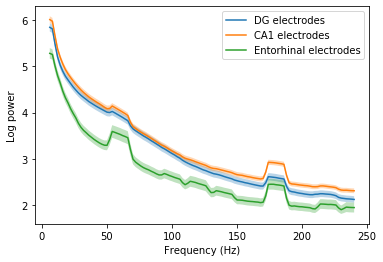

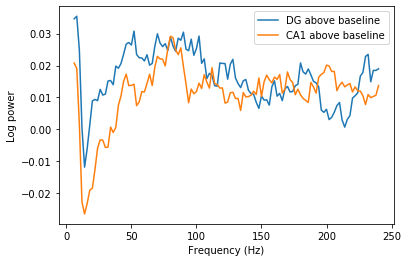

In [121]:
print('DG electrodes: '+str(DG_pows.shape[0]))
print('CA1 electrodes: '+str(CA1_pows.shape[0]))
print('Entorhinal electrodes: '+str(ENT_pows.shape[0]))

# DG
plot(freqs_done,np.mean(DG_pows,0))
DG_SE = np.std(DG_pows,0)/np.sqrt(DG_pows.shape[0])
fill_between(freqs_done, np.mean(DG_pows,0)-DG_SE, np.mean(DG_pows,0)+DG_SE, alpha = 0.3)

#CA1
plot(freqs_done,np.mean(CA1_pows,0))
CA1_SE = np.std(CA1_pows,0)/np.sqrt(CA1_pows.shape[0])
fill_between(freqs_done, np.mean(CA1_pows,0)-CA1_SE, np.mean(CA1_pows,0)+CA1_SE, alpha = 0.3)

# Entorhinal
plot(freqs_done,np.mean(ENT_pows,0))
ENT_SE = np.std(ENT_pows,0)/np.sqrt(ENT_pows.shape[0])
fill_between(freqs_done, np.mean(ENT_pows,0)-ENT_SE, np.mean(ENT_pows,0)+ENT_SE, alpha = 0.3)

# plot(freqs_done,np.mean(CA1_baseline,0))
# plot(freqs_done,np.mean(DG_baseline,0))
xlabel('Frequency (Hz)')
ylabel('Log power')
legend(['DG electrodes','CA1 electrodes','Entorhinal electrodes'])
show()

plot(freqs_done,np.mean(DG_pows,0)-np.mean(DG_baseline,0))
plot(freqs_done,np.mean(CA1_pows,0)-np.mean(CA1_baseline,0))
# plot(freqs_done,np.mean(ENT_pows,0)-np.mean(ENT_baseline,0))
xlabel('Frequency (Hz)')
ylabel('Log power')
legend(['DG above baseline','CA1 above baseline','Entorhinal above baseline']);

## Load all the recalls and get a timestamp for every ripple that starts from -600:-100 ms

## bulk load data

In [272]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used (note that exp is defined in first cell so can get exp_df above)
selected_period = 'surrounding_recall' # surrounding_recall # whole_retrieval # encoding 
recall_type_switch = 6

recall_minimum = 2000 # used if recall_type_switch = 3
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC 
remove_soz_ictal = False
###

# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []; recall_index_array = []

electrode_labels = []; channel_coords = []; channel_nums = []

# for seed in np.arange(44448,44499):
#     print(seed); ripple_array = []; sub_names = []

# Makes most sense to take half the subjects 
if exp == 'FR1':
    np.random.seed(44462) # seed 44462 gives 25,845 of 60,417 recall trials (42.8%). Or 57/167 (34.1% of subs)
    from SWRmodule import total_sub_names_FR1 # all the unique sub names for FR1 task in df
    total_sub_names = copy(total_sub_names_FR1)
    proportion_subs = 0.5 # it's really 0.5 of initial pre-localization.pairs subs. So comes out to numbers above. And what we want to match for catFR1
elif exp == 'catFR1':
    np.random.seed(44455) # seed 44455 gives 20,393 of 50,053 recall trials (40.7%). Or 47/136 (34.6% of subs)
    from SWRmodule import total_sub_names_catFR1 # all the unique sub names for FR1 task in df
    total_sub_names = copy(total_sub_names_catFR1)
    proportion_subs = 0.35 # 0.5
random_half_sub_names = np.random.permutation(np.unique(total_sub_names))[:int(np.floor(len(np.unique(total_sub_names))*proportion_subs))]
random_half_sub_names[:10] # just to see them
random_half_sub_names[-10:]
half_sub_idxs = np.array(findAinB(random_half_sub_names,exp_df.subject))
half_df = exp_df.iloc[half_sub_idxs]

for row in half_df.itertuples(): #sub_df.itertuples():  #half_df.itertuples(): ### DON'T CHANGE THIS TO EXP
    try:
        sub = row.subject; session = row.session; exp = row.experiment

        path_name = '/scratch/john/SWR_scratch/'+subfolder
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+'_'+soz_label+'.p') 
        with open(fn,'rb') as f:
            dat = pickle.load(f)

            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
            if selected_period == 'whole_retrieval':
                if np.shape(dat['fr_array'])[0]!=np.shape(dat['ripple_array'])[0]:
                    print(sub+str(session))
                fr_array = superVstack(fr_array,dat['fr_array'])
            if selected_period == 'encoding':
                serialpos_array.extend(dat['serialpos_array'])
            if selected_period == 'surrounding_recall': # ~~~
                serialpos_array.extend(dat['serialpos_array']); list_recall_num_array.extend(dat['list_recall_num_array']) # ~~
                rectime_array.extend(dat['rectime_array']); recall_before_intrusion_array.extend(dat['recall_before_intrusion_array'])
                recall_position_array.extend(dat['recall_position_array']); recall_index_array.extend(dat['recall_index_array'])
            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
            channel_nums.extend(dat['channel_nums'])
            list_num_key.extend(dat['list_num_key'])

    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  
print('**Done reading data**')
        
# loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)
subject_name_array,session_name_array,electrode_array,channel_coords_array,channel_nums_array = getSubSessPredictorsWithChannelNums(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords,channel_nums)

if selected_period == 'surrounding_recall':
    if recall_type_switch == 4:
        temp_recall_idxs = np.array(recall_position_array)==1
    elif recall_type_switch == 6:
        temp_recall_idxs = np.array(recall_position_array)>1
    elif recall_type_switch == 8:
        temp_recall_idxs = np.array(recall_position_array)==2
    else:
        temp_recall_idxs = np.array(recall_position_array)>0
        
    subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
    session_name_array = np.array(session_name_array)[temp_recall_idxs]
    channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
    ripple_array = np.array(ripple_array)[temp_recall_idxs]
    serialpos_array = np.array(serialpos_array)[temp_recall_idxs]
    list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
    rectime_array = np.array(rectime_array)[temp_recall_idxs]
    recall_before_intrusion_array = np.array(recall_before_intrusion_array)[temp_recall_idxs]
    recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
    list_num_key = np.array(list_num_key)[temp_recall_idxs]
    recall_index_array = np.array(recall_index_array)[temp_recall_idxs]
    
print('**Done translating to ripple_array frame**!!')
print('...')
print('% of all subjects for '+exp)
if exp == 'catFR1':
    len(np.unique(sub_names))/136*100 # % HPC subs for catFR1
    print('% of recalls for '+exp)
    ripple_array.shape[0]/50053*100 # % recalls for catFR1
if exp == 'FR1':
    len(np.unique(sub_names))/167*100 # % HPC subs for catFR1
    print('% of recalls for '+exp)
    ripple_array.shape[0]/60417*100 # % recalls for catFR1

array(['R1325C', 'R1310J', 'R1077T', 'R1288P', 'R1044J', 'R1108J',
       'R1002P', 'R1131M', 'R1316T', 'R1215M'], dtype='<U6')

array(['R1306E', 'R1137E', 'R1105E', 'R1048E', 'R1138T', 'R1122E',
       'R1094T', 'R1236J', 'R1120E', 'R1338T'], dtype='<U6')

2020-12-12_00-41-07: DF Exception: Sub: R1243T, Sess: 3, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_FR1_R1243T_3_HPC_surrounding_recall_soz_in.p', file: <ipython-input-272-a47990d41d2d>, line no: 60
2020-12-12_00-41-08: DF Exception: Sub: R1316T, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_FR1_R1316T_0_HPC_surrounding_recall_soz_in.p', file: <ipython-input-272-a47990d41d2d>, line no: 60
2020-12-12_00-41-09: DF Exception: Sub: R1342M, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_FR1_R1342M_1_HPC_surrounding_recall_soz_in.p', file: <ipython-input-272-a47990d41d2d>, line no: 60
**Done reading data**
**Done translating to ripple_array frame**!!
...
% of all subjects for FR1


34.13173652694611

% of recalls for FR1


25.30744657960508

## only run next two if recalculating SWR recall times

In [255]:
## DO YOU WANT TO SELECT A SUBFIELD or OUTPUT POSITION?? ##  

select_subfield = True   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to FALSE for ENT and PHC

### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_list_position = 0 #[1,2,3] #[12]  # select only recalls at given position from encoding list. 
                                         # 0 means it's off. Must be list
select_less_than_rectime = 0             # select only recalls < this number
select_greater_than_rectime = 0          # select only recalls > this number
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions

# select for subfield if HPC
if select_subfield == True:
    location_selected = 'dg' #'dg' # 'ca3' # 'dg' 'ca1' # sub # ['dg','ca1']
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''
desired_sample_rate = 500.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate


start_array,end_array = getStartEndArrays(ripple_array) # get start array
 
# if selected an output position
if select_ordinal_position > 0:
    if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
        ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
    selected_recalls = ordinal_position_array==select_ordinal_position
elif type(select_list_position) == list:
    selected_recalls = [sp in select_list_position for sp in serialpos_array]
elif select_intrusions_next == 1:
    selected_recalls = np.array(recall_before_intrusion_array)==True
elif select_less_than_rectime > 0:
    selected_recalls = np.array(rectime_array)<=select_less_than_rectime
elif select_greater_than_rectime > 0:
    selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
elif type(select_lists_with_recalls) == list:
    selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
else:
    selected_recalls = np.ones(len(start_array),dtype=bool)
    
# get locations if selected

if select_subfield == True:
    # create the full vector of location name predictors
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(start_array))

# gotta translate this to new frame as well from idxs in load step if selected subfield
if select_subfield == True: 
    location_mask = location_mask[temp_recall_idxs] 

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2
    
# translate these predictors to vector and select recalls
start_array = start_array[updated_recalls]
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
recall_index_array = recall_index_array[updated_recalls] # for subject-level analysis
channel_nums_array = channel_nums_array[updated_recalls]
    
print('Got start_array with '+str(start_array.shape[0])+' trials!')   

Got start_array with 5173 trials!


## go through every recall trial, grab the times of the SWRs, and log in a df with the recall event index

In [293]:
# note: location is selected above using location_selected = XXX
#  so these are all from the same location

save_values = 1

SWR_df = pd.DataFrame()
SWR_df['recall_idx'] = []; SWR_df['subject'] = []; SWR_df['session'] = []; 
SWR_df['channel'] = []; SWR_df['SWR_time'] = [];

unique_sessions = np.unique(session_name_array)
for sub_sess in unique_sessions:
    sub = sub_sess.split('-')[0]
    session = int(sub_sess.split('-')[1])
    sub_sess_idx = (session_name_array==sub_sess) & (subject_name_array==sub)
    session_start_array = start_array[sub_sess_idx]
    session_channel_nums_array = channel_nums_array[sub_sess_idx]
    session_recall_index_array = recall_index_array[sub_sess_idx]

    unique_channels = np.unique(session_channel_nums_array)
    for channel in unique_channels:
        channel_start_array = session_start_array[np.where(session_channel_nums_array==channel)[0]]
        channel_recall_index_array = session_recall_index_array[np.where(session_channel_nums_array==channel)[0]]
        
        for i in range(len(channel_start_array)):
            datarow = channel_start_array[i]
            recall_idx = channel_recall_index_array[i]
            
            SWR_starts = np.where(datarow)[0]            
            for ripple_time in SWR_starts:
                temp_time = (ripple_time*2)-2000 # realign to 0
                temp_df = {'recall_idx':recall_idx , 'subject': sub, 'session': session,
                           'channel': channel, 'SWR_time': temp_time}  # *2 bc everything is at sr=500
                SWR_df = SWR_df.append(temp_df, ignore_index = True) 

if save_values == 1:
    path_name = '/home1/john/SWR/compiled/ripple_time_dfs/'
    if os.path.isdir(path_name) == False:
        os.mkdir(path_name)
    fn = os.path.join(path_name,
        'SWR_df_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+'.p')            
    with open(fn,'wb') as f:
        pickle.dump({'SWR_df':SWR_df}, f)
    print('done saving')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 5173 but corresponding boolean dimension is 15290

## load SWR_df and go through every sub_sess, grab the right recalls using recall_idx, and grab the eeg from every one

In [298]:
# run "load bulk data" above first to get right setup variables then load from here:
location_selected = 'dg' # 'dg'

path_name = '/home1/john/SWR/compiled/ripple_time_dfs/'
fn = os.path.join(path_name,
    'SWR_df_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+'.p') 
with open(fn,'rb') as f:
    dat = pickle.load(f)
    SWR_df = dat['SWR_df']
SWR_df

,recall_idx,subject,session,channel,SWR_time
0,41.0,R1020J,0.0,74.0,1984.0
1,70.0,R1020J,0.0,74.0,258.0
2,94.0,R1020J,0.0,74.0,1632.0
3,118.0,R1020J,0.0,74.0,-1512.0
4,118.0,R1020J,0.0,74.0,-554.0
...,...,...,...,...,...
7863,770.0,R1338T,2.0,135.0,-2000.0
7864,813.0,R1338T,2.0,135.0,240.0
7865,813.0,R1338T,2.0,135.0,1958.0
7866,900.0,R1338T,2.0,135.0,-528.0


In [300]:
from ptsa.data.filters import MorletWaveletFilter

save_values = 1

psth_start = -2000
psth_end = 2000
eeg_buffer = 500
freqs = np.arange(25,225.1,1)
morlet_dist = 200 # how many ms to keep on either side of SWR_start
SWR_keep_range = [-500,0] # keep SWRs that occurred at these time points

for row in half_df.itertuples(): #sub_df.itertuples():  #half_df.itertuples(): ### DON'T CHANGE THIS TO EXP
    
    SWR_keep = []
    sub = row.subject; session = row.session 

    if sum((SWR_df.session==session) & (SWR_df.subject==sub)) > 0: # if subject has electrodes in this location
    
        exp = row.experiment
        mont = int(row.montage); loc = int(row.localization)
        reader = CMLReadDFRow(row)
        pairs = reader.load('pairs')
        evs = reader.load('task_events')
        evs_free_recall = evs[(evs.type=='REC_WORD')]

        sub_sess_df = SWR_df[(SWR_df.subject==sub) & (SWR_df.session==session)]

        unique_recall_idxs = np.unique(sub_sess_df.recall_idx)
        # take only evs that have recalls
        eeg_events = evs_free_recall[np.array([rec in unique_recall_idxs for rec in np.array(evs_free_recall.index)])]

        # now get EEG for those recalls so can select from that 3D array using index and channel below

        # but first correct the EEG
        eeg_events = correctEEGoffset(sub,session,exp,reader,eeg_events)

        eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer, 
                                  rel_stop=psth_end+eeg_buffer, clean=True, scheme=pairs) #**
        # events X electrodes X time
        sr = eeg.samplerate

        # if weird samplerate, add a few ms to make the load work
        if (499<sr<500) | (998<sr<1000):
            time_add = 1
            if (499<sr<500):
                sr = 500
            elif (998<sr<1000):
                sr = 1000
            while eeg.shape[2] < (psth_end-psth_start+2*eeg_buffer)/(1000/sr):
                eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer,
                                      rel_stop=psth_end+eeg_buffer+time_add, clean=True, scheme=pairs)
                if time_add>50: #** 
                    sys.exit()
                time_add+=1
            eeg.samplerate = sr # need to overwrite those that were just fixed

        eeg_ptsa = eeg.to_ptsa()
        eeg = None # clear variable
        
        # don't need all these channels, so take only the good ones! but keep track of the numbers for later
        unique_channels = np.unique(sub_sess_df.channel)
        pair_names = [pairs.iloc[int(ch)].label for ch in unique_channels]
        eeg_ptsa = eeg_ptsa.sel(channel=pair_names)

        # line removal...don't do 120 for now
        eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
        eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[178.,182.], filt_type='stop', order=4).filter()

        # use PTSA Morlet
        wf = MorletWaveletFilter(timeseries=eeg_ptsa, freqs=freqs, width=5, output='power') # width is num_cycles 
        pow_wavelet = wf.filter()
        pows = pow_wavelet.data[:, :, :, int((eeg_buffer/1000.)*sr):-int((eeg_buffer/1000.)*sr)]
        pows = np.log10(pows) # freqs X evs X elecs X time
        # to plot in debugger: matshow(pows[:, event, channel, :], fignum=0, aspect='auto', cmap='RdBu_r'); show()

        for channel_idx in range(len(unique_channels)):
            for recall_idx in unique_recall_idxs:
                # for this channel and this recall in the EEG find all the ripple_starts
                recall_SWR_times = sub_sess_df[(sub_sess_df.channel==unique_channels[channel_idx]) \
                                             & (sub_sess_df.recall_idx==recall_idx)].SWR_time

                for recall_time in recall_SWR_times:
                    # make sure enough room on either side and it's in desired range to keep SWRs
                    if abs(recall_time)<=(psth_end-morlet_dist) and recall_time>=SWR_keep_range[0] and recall_time<=SWR_keep_range[1]:
                        morlet_range = [(recall_time-morlet_dist-psth_start)/(1000/sr),(recall_time+morlet_dist-psth_start)/(1000/sr)]

                        # got EEG for each unique recall_idx so get idx in EEG for the right one
                        current_recall = int(np.where(unique_recall_idxs==recall_idx)[0]) 

                        # ripple X freq X time
                        SWR_keep.append(pows[:,current_recall,int(channel_idx),int(morlet_range[0]):int(morlet_range[1])])  

        # save separate for each sub
        if save_values == 1:
        
            from joblib import dump

            path_name = '/scratch/john/SWR_spectrograms/'
            if os.path.isdir(path_name) == False:
                os.mkdir(path_name)
            fn = os.path.join(path_name,
                'SWR_spect_'+sub+'_'+str(session)+'_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+'.lzma')            
            with open(fn, 'wb') as f:
                dump(SWR_keep, f, compress=('lzma', 3))
            print('done saving '+sub+'-'+str(session))
            print(np.shape(SWR_keep))
print('*ALL* DONE')

/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1020J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1020J/tal/R1020J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  1.8537330627441406
done saving R1020J-0
(20, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1022J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1022J/tal/R1022J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239

CPP total time wavelet loop:  0.37118077278137207
done saving R1022J-0
(7, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1033D/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1033D/tal/R1033D_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1033D/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1033D/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.8726260662078857
done saving R1033D-0
(10, 201, 640)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1034D/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1034D/tal/R1034D_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1034D/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1034D/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.5369491577148438
done saving R1034D-0
(9, 201, 640)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1034D/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1034D/tal/R1034D_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1034D/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1034D/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.5821378231048584
done saving R1034D-1
(4, 201, 640)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1048E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1048E/tal/R1048E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1048E/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1048E/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  1.3797039985656738
done saving R1048E-0
(36, 201, 200)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1056M/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1056M/tal/R1056M_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1056M/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1056M/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.4440798759460449
done saving R1056M-0
(4, 201, 200)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1065J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1065J/tal/R1065J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1065J/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1065J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  8.838380098342896
done saving R1065J-0
(129, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1065J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1065J/tal/R1065J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1065J/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1065J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  9.108023405075073
done saving R1065J-1
(97, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1065J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1065J/tal/R1065J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1065J/experiments/FR1/sessions/2/ephys/current_processed/sources.json
/data/eeg/R1065J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  7.850205421447754
done saving R1065J-2
(62, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1065J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1065J/tal/R1065J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1065J/experiments/FR1/sessions/3/ephys/current_processed/sources.json
/data/eeg/R1065J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  8.466887950897217
done saving R1065J-3
(78, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1065J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1065J/tal/R1065J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1065J/experiments/FR1/sessions/4/ephys/current_processed/sources.json
/data/eeg/R1065J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  7.893926382064819
done saving R1065J-4
(91, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1065J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1065J/tal/R1065J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1065J/experiments/FR1/sessions/5/ephys/current_processed/sources.json
/data/eeg/R1065J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  9.080238342285156
done saving R1065J-5
(114, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1080E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1080E/tal/R1080E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1080E/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1080E/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  1.7604296207427979
done saving R1080E-0
(20, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1080E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1080E/tal/R1080E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1080E/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1080E/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  1.9826176166534424
done saving R1080E-1
(45, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1083J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1083J/tal/R1083J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1083J/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1083J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.50008225440979
done saving R1083J-0
(7, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1083J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1083J/tal/R1083J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1083J/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1083J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.3048670291900635
done saving R1083J-1
(4, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1083J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1083J/tal/R1083J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1083J/experiments/FR1/sessions/2/ephys/current_processed/sources.json
/data/eeg/R1083J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.5317637920379639
done saving R1083J-2
(8, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1083J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1083J/tal/R1083J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1083J/experiments/FR1/sessions/3/ephys/current_processed/sources.json
/data/eeg/R1083J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.46682262420654297
done saving R1083J-3
(10, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1083J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1083J/tal/R1083J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1083J/experiments/FR1/sessions/4/ephys/current_processed/sources.json
/data/eeg/R1083J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.1147453784942627
done saving R1083J-4
(3, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1094T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1094T/tal/R1094T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1094T/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1094T/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.27399516105651855
done saving R1094T-0
(1, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1094T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1094T/tal/R1094T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1094T/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1094T/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.3109476566314697
done saving R1094T-1
(5, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1094T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1094T/tal/R1094T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1094T/experiments/FR1/sessions/2/ephys/current_processed/sources.json
/data/eeg/R1094T/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.0983128547668457
done saving R1094T-2
(2, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1096E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1096E/tal/R1096E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1096E/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1096E/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.23498320579528809
done saving R1096E-0
(6, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1102P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1102P/tal/R1102P_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1102P/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1102P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.11013460159301758
done saving R1102P-0
(1, 201, 200)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1108J/localizations/0/montages/1/neuroradiology/current_processed/pairs.json
/data/eeg/R1108J_1/tal/R1108J_1_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1108J/experiments/FR1/sessions/2/ephys/current_processed/sources.json
/data/eeg/R1108J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.18381118774414062
done saving R1108J-2
(2, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1112M/tal/R1112M_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1112M/eeg.noreref/R1112M_FR1_0_01Dec15_1545.params.txt
/data/eeg/R1112M/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.10101914405822754
done saving R1112M-0
(1, 201, 200)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1112M/tal/R1112M_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1112M/eeg.noreref/R1112M_FR1_1_03Dec15_0938.params.txt
/data/eeg/R1112M/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.2845287322998047
done saving R1112M-1
(2, 201, 200)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1112M/tal/R1112M_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/experiments/FR1/sessions/2/ephys/current_processed/sources.json
/data/eeg/R1112M/eeg.noreref/R1112M_FR1_2_05Dec15_0921.params.txt
/data/eeg/R1112M/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.02138829231262207
done saving R1112M-2
(0,)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1122E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1122E/tal/R1122E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1122E/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1122E/eeg.noreref/R1122E_FR1_0_15Jan16_1327.params.txt
/data/eeg/R1122E/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  2.730250597000122
done saving R1122E-0
(56, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1122E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1122E/tal/R1122E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1122E/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1122E/eeg.noreref/R1122E_FR1_1_16Jan16_1208.params.txt
/data/eeg/R1122E/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  4.8902764320373535
done saving R1122E-1
(100, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1137E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1137E/tal/R1137E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1137E/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1137E/eeg.noreref/R1137E_FR1_0_22Jan16_1607.params.txt
/data/eeg/R1137E/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  1.6960172653198242
done saving R1137E-0
(40, 201, 200)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1137E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1137E/tal/R1137E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1137E/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1137E/eeg.noreref/R1137E_FR1_1_24Jan16_1336.params.txt
/data/eeg/R1137E/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  2.2171733379364014
done saving R1137E-1
(53, 201, 200)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1137E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1137E/tal/R1137E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1137E/experiments/FR1/sessions/2/ephys/current_processed/sources.json
/data/eeg/R1137E/eeg.noreref/R1137E_FR1_2_25Jan16_1110.params.txt
/data/eeg/R1137E/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  2.4615275859832764
done saving R1137E-2
(47, 201, 200)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1138T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1138T/tal/R1138T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1138T/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1138T/eeg.noreref/R1138T_FR1_0_03Feb16_1453.params.txt
/data/eeg/R1138T/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.5002269744873047
done saving R1138T-0
(5, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1154D/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1154D/tal/R1154D_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1154D/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1154D/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  3.392348289489746
done saving R1154D-1
(35, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1154D/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1154D/tal/R1154D_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1154D/experiments/FR1/sessions/2/ephys/current_processed/sources.json
/data/eeg/R1154D/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  2.266106128692627
done saving R1154D-2
(35, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1168T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1168T/tal/R1168T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1168T/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1168T/eeg.noreref/R1168T_FR1_0_27Apr16_1941.params.txt
/data/eeg/R1168T/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.9184415340423584
done saving R1168T-0
(7, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1168T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1168T/tal/R1168T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1168T/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1168T/eeg.noreref/R1168T_FR1_1_29Apr16_1454.params.txt
/data/eeg/R1168T/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  1.0477497577667236
done saving R1168T-1
(11, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1168T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1168T/tal/R1168T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1168T/experiments/FR1/sessions/2/ephys/current_processed/sources.json
/data/eeg/R1168T/eeg.noreref/R1168T_FR1_2_30Apr16_2113.params.txt
/data/eeg/R1168T/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  1.2245981693267822
done saving R1168T-2
(12, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1203T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1203T/tal/R1203T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1203T/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1203T/eeg.noreref/R1203T_FR1_0_07Aug16_2008.params.txt
/data/eeg/R1203T/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.5271923542022705
done saving R1203T-0
(1, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1215M/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1215M/tal/R1215M_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1215M/experiments/FR1/sessions/2/ephys/current_processed/sources.json
/data/eeg/R1215M/eeg.noreref/R1215M_FR1_2_12Sep16_1440.params.txt
/data/eeg/R1215M/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.3027632236480713
done saving R1215M-2
(5, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1217T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1217T/tal/R1217T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1217T/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1217T/eeg.noreref/R1217T_FR1_0_02Sep16_1506.params.txt
/data/eeg/R1217T/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.896761417388916
done saving R1217T-0
(2, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1217T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1217T/tal/R1217T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1217T/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1217T/eeg.noreref/R1217T_FR1_1_06Sep16_1458.params.txt
/data/eeg/R1217T/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.3301975727081299
done saving R1217T-1
(2, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1217T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1217T/tal/R1217T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1217T/experiments/FR1/sessions/2/ephys/current_processed/sources.json
/data/eeg/R1217T/eeg.noreref/R1217T_FR1_2_07Sep16_1537.params.txt
/data/eeg/R1217T/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.9083249568939209
done saving R1217T-2
(3, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1221P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1221P/tal/R1221P_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1221P/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1221P/eeg.noreref/R1221P_FR1_1_18Sep16_1158.params.txt
/data/eeg/R1221P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.057665348052978516
done saving R1221P-1
(3, 201, 205)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1236J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1236J/tal/R1236J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1236J/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1236J/eeg.noreref/R1236J_FR1_0_27Oct16_1928.params.txt
/data/eeg/R1236J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.38042283058166504
done saving R1236J-0
(1, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1236J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1236J/tal/R1236J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1236J/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1236J/eeg.noreref/R1236J_FR1_1_29Oct16_1723.params.txt
/data/eeg/R1236J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.36165833473205566
done saving R1236J-1
(3, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1236J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1236J/tal/R1236J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1236J/experiments/FR1/sessions/2/ephys/current_processed/sources.json
/data/eeg/R1236J/eeg.noreref/R1236J_FR1_2_30Oct16_1615.params.txt
/data/eeg/R1236J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.35878634452819824
done saving R1236J-2
(2, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1236J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1236J/tal/R1236J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1236J/experiments/FR1/sessions/3/ephys/current_processed/sources.json
/data/eeg/R1236J/eeg.noreref/R1236J_FR1_3_02Nov16_1819.params.txt
/data/eeg/R1236J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.1874852180480957
done saving R1236J-3
(1, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1243T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1243T/tal/R1243T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1243T/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1243T/eeg.noreref/R1243T_FR1_1_28Nov16_1544.params.txt
/data/eeg/R1243T/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.21822834014892578
done saving R1243T-1
(1, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1243T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1243T/tal/R1243T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1243T/experiments/FR1/sessions/2/ephys/current_processed/sources.json
/data/eeg/R1243T/eeg.noreref/R1243T_FR1_2_02Dec16_2009.params.txt
/data/eeg/R1243T/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.2875227928161621
done saving R1243T-2
(1, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1293P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1293P/tal/R1293P_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.24808764457702637
done saving R1293P-3
(1, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1293P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1293P/tal/R1293P_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.08794903755187988
done saving R1293P-4
(0,)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1306E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1306E/tal/R1306E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.08042788505554199
done saving R1306E-1
(0,)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1310J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1310J/tal/R1310J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1310J/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1310J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  1.090480089187622
done saving R1310J-0
(15, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1310J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1310J/tal/R1310J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1310J/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1310J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.6199643611907959
done saving R1310J-1
(8, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1311T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1311T/tal/R1311T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1311T/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1311T/eeg.noreref/R1311T_FR1_0_20Jun17_1506.params.txt
/data/eeg/R1311T/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.14092230796813965
done saving R1311T-0
(2, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1311T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1311T/tal/R1311T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1311T/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1311T/eeg.noreref/R1311T_FR1_1_21Jun17_1131.params.txt
/data/eeg/R1311T/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.21771812438964844
done saving R1311T-1
(0,)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1311T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1311T/tal/R1311T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1311T/experiments/FR1/sessions/2/ephys/current_processed/sources.json
/data/eeg/R1311T/eeg.noreref/R1311T_FR1_2_22Jun17_1517.params.txt
/data/eeg/R1311T/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.1817028522491455
done saving R1311T-2
(2, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1325C/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1325C/tal/R1325C_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))


CPP total time wavelet loop:  0.035430192947387695
done saving R1325C-0
(0,)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1325C/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1325C/tal/R1325C_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))


CPP total time wavelet loop:  0.13594675064086914
done saving R1325C-1
(0,)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1334T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1334T/tal/R1334T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  1.8587455749511719
done saving R1334T-0
(24, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1334T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1334T/tal/R1334T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  1.5550792217254639
done saving R1334T-1
(21, 201, 400)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1338T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1338T/tal/R1338T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.04007077217102051
done saving R1338T-1
(0,)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1338T/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1338T/tal/R1338T_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  0.1561741828918457
done saving R1338T-2
(0,)
*ALL* DONE


### # load and plot

In [336]:
from joblib import load
from scipy.signal import resample
path_name = '/scratch/john/SWR_spectrograms/'

location_selected = 'ca1' # 'ca1'

first_append = 1
for row in half_df.itertuples(): #sub_df.itertuples():  #half_df.itertuples(): ### DON'T CHANGE THIS TO EXP
    try:
        temp_SWR = []
        sub = row.subject; session = row.session; exp = row.experiment
        fn = os.path.join(path_name,
            'SWR_spect_'+sub+'_'+str(session)+'_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+'.lzma') 
        with open(fn, 'rb') as f:
            temp_SWR = load(f)
            if np.shape(temp_SWR)[2] != 400: # if not sr=1000 with +/- 200 ms
                temp_SWR = resample(temp_SWR,400,axis=2)
            if first_append == 1: # identify where to create empty matrix
                print('first load')
                SWR_across_sessions = np.empty((0,np.shape(temp_SWR)[1],np.shape(temp_SWR)[2]))            
                first_append = 0
            SWR_across_sessions = np.append(SWR_across_sessions,temp_SWR,axis=0)    
        print('done loading '+sub+'_'+str(session)+' who has '+str(np.shape(temp_SWR)[0])+
              ' trials and '+str(np.shape(temp_SWR)[2])+' samples')
    except:
        continue

first load
done loading R1002P_0 who has 25 trials and 400 samples
done loading R1002P_1 who has 11 trials and 400 samples
done loading R1020J_0 who has 10 trials and 400 samples
done loading R1022J_0 who has 5 trials and 400 samples
done loading R1027J_0 who has 1 trials and 400 samples
done loading R1033D_0 who has 10 trials and 400 samples
done loading R1034D_0 who has 5 trials and 400 samples
done loading R1034D_1 who has 4 trials and 400 samples
done loading R1035M_0 who has 8 trials and 400 samples
done loading R1048E_0 who has 139 trials and 400 samples
done loading R1056M_0 who has 5 trials and 400 samples
done loading R1065J_0 who has 113 trials and 400 samples
done loading R1065J_1 who has 127 trials and 400 samples
done loading R1065J_2 who has 96 trials and 400 samples
done loading R1065J_3 who has 130 trials and 400 samples
done loading R1065J_4 who has 141 trials and 400 samples
done loading R1065J_5 who has 139 trials and 400 samples
done loading R1077T_0 who has 18 tria

In [ ]:
from general import parula_map

print(str(np.shape(SWR_across_sessions)[0])+' ripples')

matshow(np.mean(stats.zscore(SWR_across_sessions,2), 0), fignum=0, aspect='auto', cmap=parula_map, vmin=0, vmax=1.6) # 'viridis'

# y-axis
gca().invert_yaxis()
ytick_size = 50
yticks(np.arange(0,len(freqs),ytick_size), np.arange(25,225.1,ytick_size,dtype=int), fontsize=12) # positions, labels
# setp(gca().get_yticklabels()[::2], visible=False) # get every other
ylabel('Frequency (Hz)', fontsize=14)

# x-axis
gca().xaxis.set_ticks_position('bottom')
xtick_size = 100
xticks(np.arange(0,2*morlet_dist+0.1,xtick_size), np.arange(-200,200+0.1,xtick_size,dtype=int),fontsize=12)
# setp(gca().get_xticklabels()[::2], visible=False)
xlabel('Time (ms)', fontsize=14)
colorbar();

1733 ripples


array([ 0.63328141,  0.61859712,  0.5838088 ,  0.59773027,  0.6019283 ,
        0.58153305,  0.53661106,  0.57278189,  0.53942036,  0.47168187,
        0.34110736,  0.18567628,  0.0131485 , -0.22672393, -0.55710741,
       -0.83588464, -1.26841073, -1.34782018, -1.30565431, -1.14674532,
       -0.8960316 , -0.67425015, -0.46329576, -0.29692323, -0.24032493,
       -0.12959042, -0.0299407 ,  0.0412091 ,  0.08764679,  0.11680456,
        0.16708918,  0.21538513,  0.21992447,  0.24498606,  0.26144785,
        0.2735664 ,  0.28169823,  0.28382961,  0.28146582,  0.27333648,
        0.26210404,  0.24732337,  0.22955121,  0.20825767,  0.18374268,
        0.15315285,  0.17678151,  0.14276322,  0.10731357,  0.07090668,
        0.10230353,  0.06109193,  0.01202697,  0.03540797, -0.02128117,
       -0.08169303, -0.03892185, -0.10393856, -0.17507066, -0.12266414,
       -0.18635795, -0.13641379, -0.21351359, -0.1499427 , -0.21175312,
       -0.14846742, -0.21518515, -0.14033943, -0.19187236, -0.09

array([9.12768714, 9.10761162, 9.07964757, 9.06364658, 9.03464314,
       8.99057962, 8.944415  , 8.87724379, 8.78966279, 8.68758984,
       8.55914725, 8.41145496, 8.24004944, 8.04649414, 7.80042986,
       7.56522176, 7.25285308, 7.16053987, 7.08416884, 7.16560163,
       7.30718722, 7.44462424, 7.5610318 , 7.6557661 , 7.7140817 ,
       7.78172845, 7.83184431, 7.87523838, 7.91368841, 7.93637593,
       7.96278042, 7.98450183, 7.98188164, 7.99200771, 7.99748465,
       7.99839433, 7.99486421, 7.98704667, 7.97510385, 7.95919783,
       7.93948429, 7.91610817, 7.88920073, 7.85887654, 7.82523057,
       7.78833425, 7.790687  , 7.7499694 , 7.70636166, 7.65984737,
       7.66061395, 7.61185402, 7.56039571, 7.56279055, 7.51031758,
       7.45519437, 7.46147852, 7.40640183, 7.34851688, 7.36032592,
       7.30326735, 7.31707841, 7.26127826, 7.27638696, 7.22208888,
       7.23777191, 7.18506887, 7.20069409, 7.14958148, 7.16466645,
       7.11509656, 7.1293284 , 7.13833507, 7.09448721, 7.10250

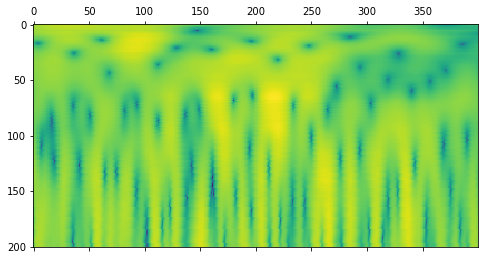

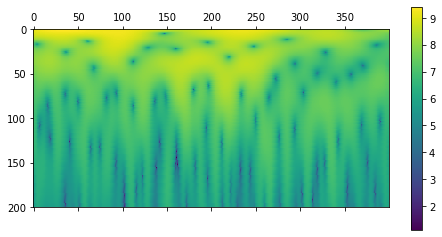

In [234]:
#look at single trials
tr = 15
matshow(stats.zscore(SWR_across_sessions[tr,:,:],1)) # zscored
stats.zscore(SWR_across_sessions[:,:,:],2)[tr,:,0]
SWR_across_sessions[tr,:,0]
matshow(SWR_across_sessions[tr,:,:]) # raw
colorbar()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)
i = 0  # first axis
ax[i].plot()
i = 1
ax[i].plot()

fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)
for i in range(len(ax)):
   # generate plots here...
    ax[i].plot()
    ax.set_xlim(), ax.set_xticks(), ax.set_xticklabels()
   # configure axis params here...
# Config fig params here.
fig.tight_layout()